In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import roc_auc_score 
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import time
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
%matplotlib notebook

# Feature enigneering

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.drop('id',axis = 1,inplace = True)
test.drop('id',axis = 1,inplace = True)

print('Number of target we remove: {:,}'.format(sum(train.cancel == -1)))
train = train[train.cancel != -1]

Number of target we remove: 3,452


In [3]:
train = train[~train['zip.code'].isnull()]
test['zip.code'].fillna(train['zip.code'].mode()[0],inplace = True)

train_copy = train.copy()
test_copy = test.copy()
train_copy.drop('cancel',axis = 1,inplace = True)
train_copy['train'] = 1
test_copy['train'] = 0
all_data = pd.concat([train_copy,test_copy],axis = 0).reset_index(drop = True)

target = train.cancel.reset_index(drop = True)
all_data_train = all_data[all_data.train == 1].drop('train',axis = 1)
all_data_test = all_data[all_data.train == 0].drop('train',axis = 1)

## Age

In [4]:
Age_threshold = 100
all_data.loc[all_data['ni.age'] > Age_threshold,'ni.age'] = np.nan

## Length at residence

In [5]:
all_data.loc[all_data['len.at.res'] > all_data['ni.age'],'len.at.res'] = np.nan

print('Length of residence null rate:{:.2%}'.format(all_data['len.at.res'].isnull().sum()/len(all_data)))

Length of residence null rate:0.57%


## tenure

In [6]:
all_data.loc[all_data['tenure'] > all_data['ni.age'],'tenure'] = np.nan

print('Tenure null rate:{:.2%}'.format(all_data['tenure'].isnull().sum()/len(all_data)))

Tenure null rate:0.10%


## Zipcode & income

In [7]:
zipcode = pd.read_csv('zip_code.csv',sep = ';')
income = pd.read_csv('US_Income.csv',encoding = 'ISO-8859-1')

all_data = all_data.merge(zipcode,left_on = 'zip.code',right_on = 'Zip',how = 'left')

# zip_income = pd.read_excel("MedianZIP-3.xlsx")
# zip_income.head()
# all_data = all_data.merge(zip_income,left_on = 'zip.code',right_on = 'Zip',how = 'left')

In [8]:
income_pivot_by_city = income.groupby('City').agg({'Mean':np.mean,
                                                   'Median':np.mean})

income_pivot_by_STATE = income.groupby('State_ab').agg({'Mean':np.mean,
                                                   'Median':np.mean,
                                                   'Households':np.sum})

In [9]:
all_data = all_data.merge(income_pivot_by_city,left_on = 'City',right_on = 'City',how = 'left')
all_data = all_data.merge(income_pivot_by_STATE,left_on = 'State',right_on = 'State_ab',how = 'left')


In [10]:
all_data.rename({'Median_x':'Median_by_City',
                'Mean_x':'Mean_by_City',
                'Households_y':'Households_by_State',
                'Median_y':'Median_by_State',
                'Mean_y':'Mean_by_State'},axis = 1,inplace = True)

In [11]:
all_data.drop(['Timezone','Daylight savings time flag','geopoint,','Zip'],axis = 1,inplace = True)

In [12]:
all_data['dwelling.type'] = np.where(all_data['dwelling.type'] == 'House','House','Other')

# Split train/split

In [13]:
all_data_train = all_data[all_data['train'] == 1].drop('train',axis = 1)
all_data_test = all_data[all_data['train'] == 0].drop('train',axis = 1)

# Fill NA with mode & median

In [14]:
def fill_na_numerical(col):
    return all_data[col].fillna(all_data[col].median())

numerical_cols = ['ni.age','len.at.res','premium','n.adults','n.children','tenure']
categorical_cols = ['zip.code','house.color','credit','coverage.type','dwelling.type','sales.channel',
                   'ni.gender','ni.marital.status','claim.ind','City','State']

In [15]:
all_data_train[numerical_cols] = all_data_train[numerical_cols].fillna(all_data_train[numerical_cols].median())

all_data_test[numerical_cols] = all_data_test[numerical_cols].fillna(all_data_train[numerical_cols].median())
all_data_test[categorical_cols] = all_data_test[categorical_cols].fillna(all_data_train[categorical_cols].mode().iloc[0])



In [16]:
all_data_train['family_size'] = all_data_train['n.adults'] + all_data_train['n.children']
all_data_test['family_size'] = all_data_test['n.adults'] + all_data_test['n.children']

# Mean Encoding

In [17]:
# def mean_encoding(col,smooth = 1):
#     all_data_train['target'] = target
#     prior = target.mean()
#     n = all_data_train.groupby(col).size()

#     means = all_data_train.groupby(col).target.mean() 
#     smooth_mean = (n*means + smooth*prior)/(n + smooth)
    
#     all_data_train[col + '_encoding'] = all_data_train[col].map(smooth_mean)
#     all_data_test[col + '_encoding'] = all_data_test[col].map(smooth_mean)

#     all_data_train[col + '_encoding'].fillna(prior,inplace = True)
#     all_data_test[col + '_encoding'].fillna(prior,inplace = True)

#     all_data_train.drop(['target',col],axis = 1,inplace = True)
#     all_data_test.drop(col,axis = 1,inplace = True)
def mean_encoding(col):
    from sklearn.model_selection import StratifiedKFold
    all_data_train['target'] = target
    prior = target.mean()
    kf = StratifiedKFold(n_splits=10,random_state = 123)
    all_data_train[col + '_encoding'] = np.nan
    all_data_test[col + '_encoding'] = np.nan

    for tr_ind, val_ind in kf.split(all_data_train.drop('target',axis = 1),target):
        X_tr, X_val = all_data_train.iloc[tr_ind], all_data_train.iloc[val_ind]
        all_data_train.loc[all_data_train.index[val_ind], col + '_encoding'] = X_val[col].map(X_tr.groupby(col).target.mean())

    all_data_train[col + '_encoding'].fillna(prior, inplace=True)
    
    all_data_test[col + '_encoding'] = all_data_test[col].map(all_data_train.groupby(col)[col + '_encoding'].mean())
    
    all_data_train.drop(['target',col],axis = 1,inplace = True)
    all_data_test.drop(col,axis = 1,inplace = True)
    
    

In [18]:
for col in categorical_cols:
    mean_encoding(col)

In [19]:
for col in ['Mean','Median']:
    all_data_train[col + '_by_City'].fillna(all_data_train[col + '_by_State'],inplace = True)
    all_data_test[col + '_by_City'].fillna(all_data_test[col + '_by_State'],inplace = True)

# Other features

In [20]:
def add_feature(dt):
    dt['p_perad'] = dt['premium']/dt['n.adults']
    dt['p_perp'] = dt['premium']/dt['family_size']

add_feature(all_data_train)
add_feature(all_data_test)
all_data_train.head()

,year,ni.age,len.at.res,premium,n.adults,n.children,tenure,Latitude,Longitude,Median_by_City,...,coverage.type_encoding,dwelling.type_encoding,sales.channel_encoding,ni.gender_encoding,ni.marital.status_encoding,claim.ind_encoding,City_encoding,State_encoding,p_perad,p_perp
0,2013,37.0,18.000000,950.507336,2.0,0.0,15.0,47.618371,-122.20308,177063.750000,...,0.251986,0.258493,0.181726,0.242003,0.257993,0.228867,0.266632,0.262544,475.253668,475.253668
1,2013,40.0,17.000000,909.346046,5.0,0.0,15.0,33.514092,-112.12285,65457.000000,...,0.231359,0.258493,0.181726,0.242003,0.235742,0.228867,0.261379,0.261379,181.869209,181.869209
2,2013,45.0,14.000000,897.084502,1.0,0.0,14.0,39.881608,-105.09953,140107.530864,...,0.231359,0.229392,0.329736,0.242338,0.257993,0.228867,0.198977,0.204957,897.084502,897.084502
3,2013,45.0,24.366136,979.039007,5.0,0.0,22.0,33.276539,-112.18717,65457.000000,...,0.231359,0.229392,0.329736,0.242338,0.257993,0.295560,0.261379,0.261379,195.807801,195.807801
4,2013,36.0,16.000000,932.379027,2.0,4.0,4.0,41.363615,-93.41494,110277.564815,...,0.251986,0.229392,0.181726,0.242338,0.235742,0.228867,0.243310,0.242984,466.189513,155.396504


# Train Test Split in training data

In [21]:
X = all_data_train
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

### Skf

In [22]:
### Random Search
def skf_cv(X, y,clf,folds = 3):
    from sklearn.model_selection import StratifiedKFold
    
    X_arr,y_arr = np.array(X),np.array(y)
    skf = StratifiedKFold(n_splits=folds,random_state = 123)
    cv_train = []
    cv_test = []
    
    for train_index, val_index in skf.split(X, y):
        x_tr,x_val = X_arr[train_index],X_arr[val_index]
        y_tr,y_val = y_arr[train_index],y_arr[val_index]
        clf.fit(x_tr,y_tr)
        predict_test = clf.predict_proba(x_val)[:,1]
        predict_train = clf.predict_proba(x_tr)[:,1]
        cv_test.append(roc_auc_score(y_val,predict_test))
        cv_train.append(roc_auc_score(y_tr,predict_train))
    return np.mean(cv_train),np.mean(cv_test)


# XGB

In [23]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.1, eta=0.02, max_delta_step=0,
       max_depth=6, min_child_weight=1, min_samples_leaf=5,
       min_samples_split=5, missing=None, n_estimators=125, n_jobs=3,
       nthread=None, objective='binary:logistic', random_state=123,
       reg_alpha=0.1, reg_lambda=0.8, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

xgb.fit(X_train,y_train)
auc_train = roc_auc_score(y_train,xgb.predict_proba(X_train)[:,1])
auc_test = roc_auc_score(y_test,xgb.predict_proba(X_test)[:,1])
print('train AUC: {train:.2%}, test AUC {test:.2%}'.format(train = auc_train,test = auc_test))

train AUC: 74.26%, test AUC 73.24%


<IPython.core.display.Javascript object>


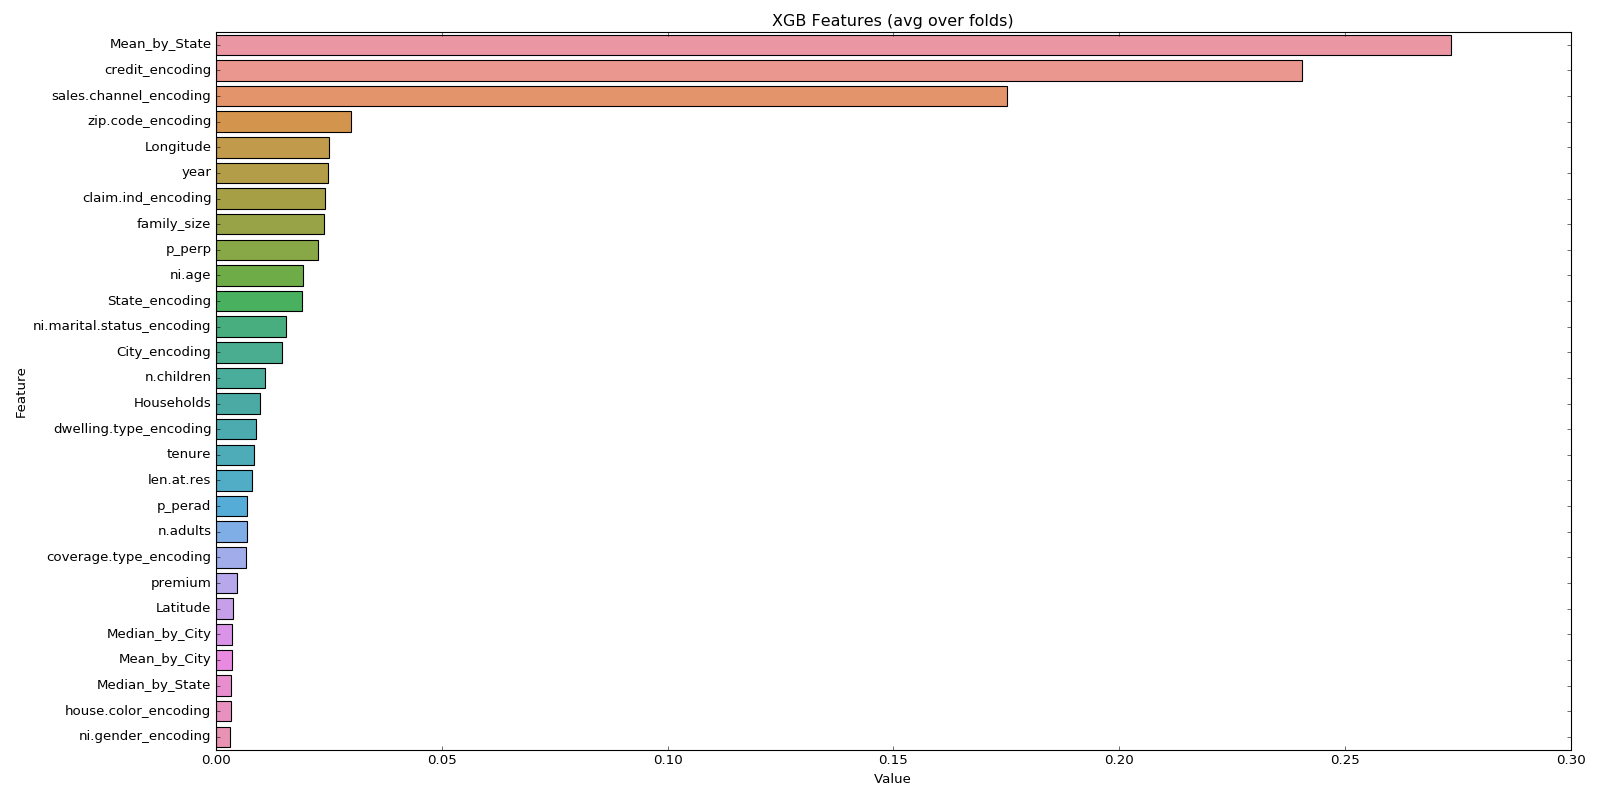

In [24]:
feature_imp = pd.DataFrame(sorted(zip(xgb.feature_importances_,X_train.columns),reverse = True), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('XGB Features (avg over folds)')
plt.tight_layout()
plt.show()

In [25]:
feature_imp = pd.DataFrame(sorted(zip(xgb.feature_importances_,X_train.columns)), columns=['Value','Feature'])
select_ft = feature_imp.sort_values(by="Value", ascending=False)["Feature"][0:15]
X_train_select =X_train[select_ft]
X_test_select =X_test[select_ft]
xgb.fit(X_train_select,y_train)
auc_train = roc_auc_score(y_train,xgb.predict_proba(X_train_select)[:,1])
auc_test = roc_auc_score(y_test,xgb.predict_proba(X_test_select)[:,1])
print('train AUC: {train:.2%}, test AUC {test:.2%}'.format(train = auc_train,test = auc_test))

train AUC: 73.65%, test AUC 72.86%


# RF

In [26]:
rf = RandomForestClassifier(class_weight = 'balanced_subsample',
                            n_estimators = 2000,
                            max_depth = 10,
                            min_samples_leaf = 15,
                            min_samples_split = 5,
                            max_features = 'sqrt',
                            random_state = 123,
                            n_jobs = 24)

rf.fit(X_train,y_train)

auc_train = roc_auc_score(y_train,rf.predict_proba(X_train)[:,1])
auc_test = roc_auc_score(y_test,rf.predict_proba(X_test)[:,1])
print('train AUC: {train:.2%}, test AUC {test:.2%}'.format(train = auc_train,test = auc_test))

train AUC: 73.25%, test AUC 72.32%


<IPython.core.display.Javascript object>


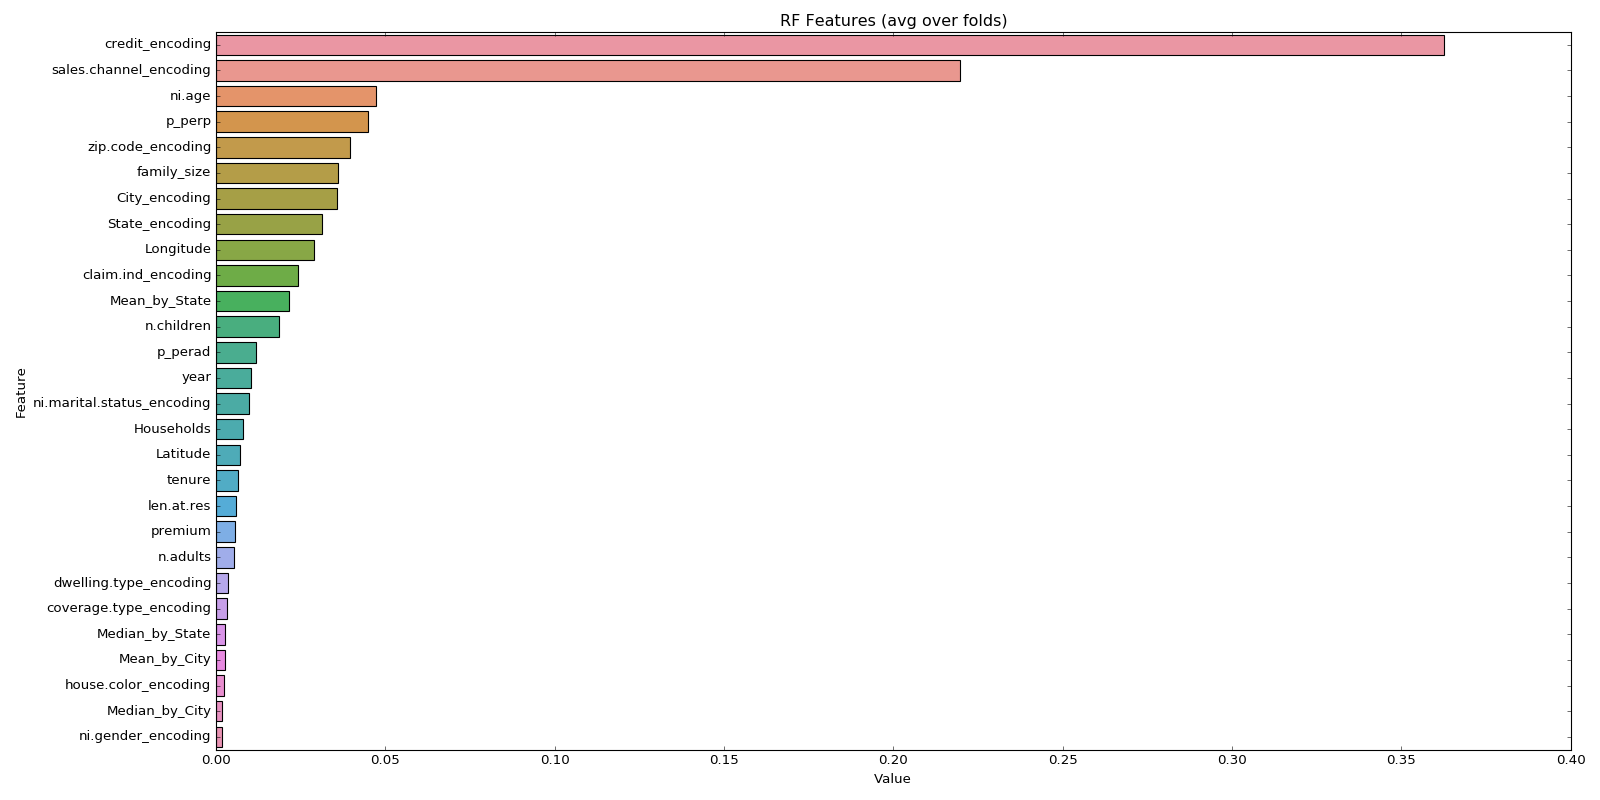

In [27]:
feature_imp = pd.DataFrame(sorted(zip(rf.feature_importances_,X_train.columns),reverse = True), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('RF Features (avg over folds)')
plt.tight_layout()
plt.show()

# LGB

In [28]:
import lightgbm as lgb

In [29]:
lgb_estimator = lgb.LGBMClassifier(num_leaves = 2**9,
                                  min_data_in_leaf = 1000,
                                   n_estimators = 2500,
                                   class_weight = 'balanced',
                                   subsample_for_bin=200000,
                                  max_depth = 9,
                                  learning_rate = 0.02,
                                  bagging_freq = 6,
                                  bagging_fraction = 0.7,
                                  reg_lambda = 0.8,
                                  random_seed = 123,
                                  metric = 'auc',
                                  objective = 'binary',
                                   boosting_type = 'dart',
                                  verbosity = -1,
                                  num_threads = 24)

lgb_estimator.fit(X_train,y_train)

auc_train = roc_auc_score(y_train,lgb_estimator.predict_proba(X_train)[:,1])
auc_test = roc_auc_score(y_test,lgb_estimator.predict_proba(X_test)[:,1])

print('train AUC: {train:.2%}, test AUC {test:.2%}'.format(train = auc_train,test = auc_test))


train AUC: 75.68%, test AUC 73.12%


<IPython.core.display.Javascript object>


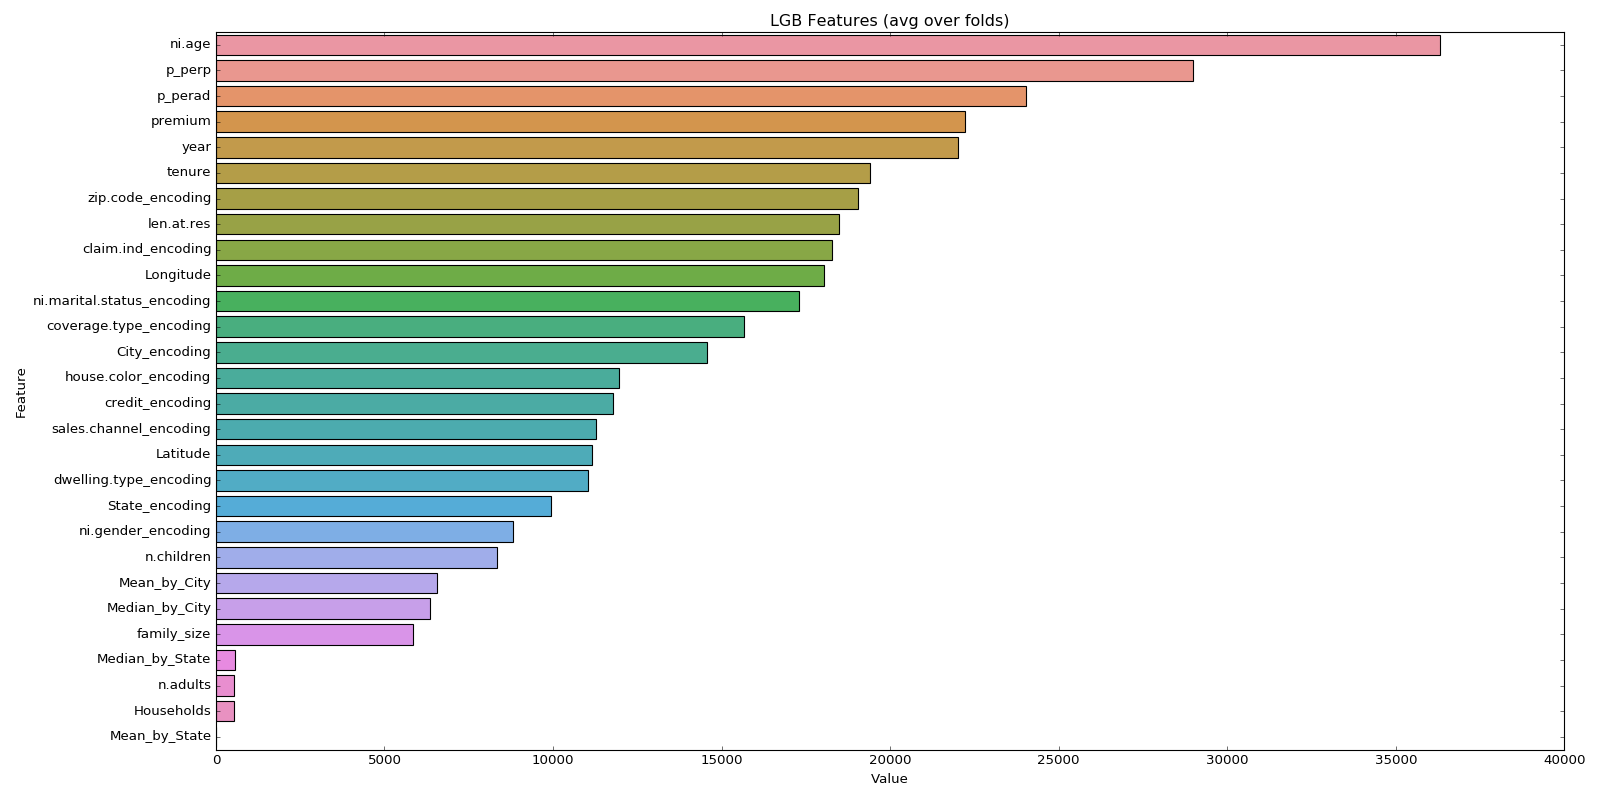

In [30]:
feature_imp = pd.DataFrame(sorted(zip(lgb_estimator.feature_importances_,X_train.columns),reverse = True), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LGB Features (avg over folds)')
plt.tight_layout()
plt.show()

# Adaboost

In [31]:
adaboost = AdaBoostClassifier(learning_rate = .1,
                             n_estimators  =200)

In [32]:
adaboost.fit(X_train,y_train)
auc_train = roc_auc_score(y_train,adaboost.predict_proba(X_train)[:,1])
auc_test = roc_auc_score(y_test,adaboost.predict_proba(X_test)[:,1])
print('train AUC: {train:.2%}, test AUC {test:.2%}'.format(train = auc_train,test = auc_test))


train AUC: 72.70%, test AUC 72.59%


<IPython.core.display.Javascript object>


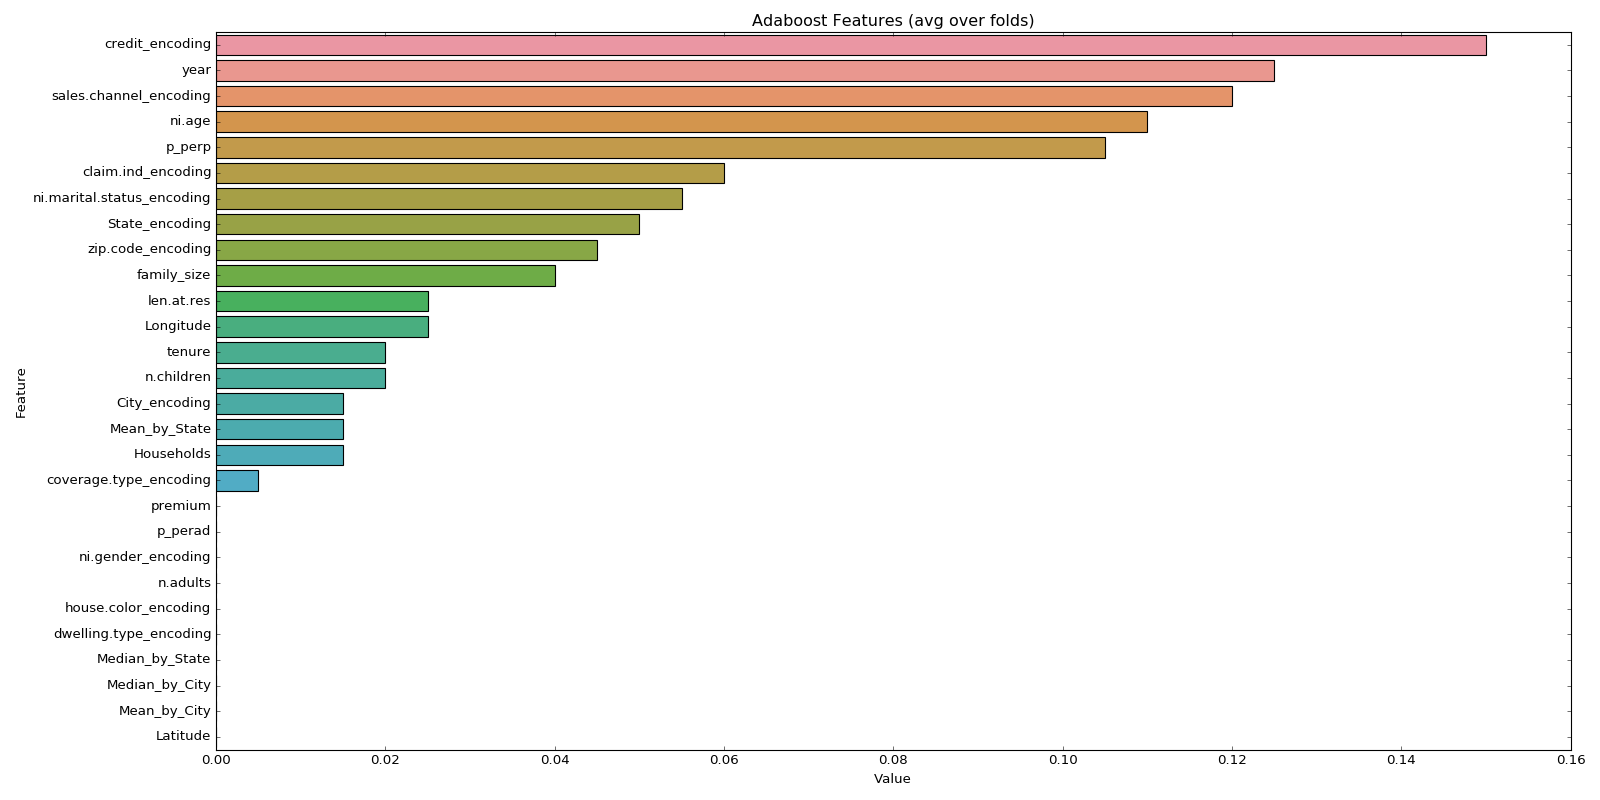

In [33]:
feature_imp = pd.DataFrame(sorted(zip(adaboost.feature_importances_,X_train.columns),reverse = True), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Adaboost Features (avg over folds)')
plt.tight_layout()
plt.show()

# NB

In [34]:
nb = GaussianNB()

# Stacking

##### 1-Level

In [24]:
from sklearn.model_selection import StratifiedKFold

def get_oof(clf, x_train, y_train, x_test):
    ntrain = x_train.shape[0]
    ntest = x_test.shape[0]
    NFOLDS = 5 # set folds for out-of-fold prediction
    kf = StratifiedKFold(n_splits = NFOLDS, random_state=123)
    
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf.split(x_train,y_train)):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict_proba(x_te)[:,1]
        oof_test_skf[i, :] = clf.predict_proba(x_test)[:,1]

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [240]:
rf_oof_train,rf_oof_test = get_oof(rf, X.values, y.values, all_data_test.values)
print('rf finish')
lgb_oof_train,lgb_oof_test = get_oof(lgb_estimator, X.values, y.values, all_data_test.values)
print('lgb finish')
xgb_oof_train, xgb_oof_test = get_oof(xgb, X.values, y.values, all_data_test.values)
print('xgb finish')
ada_oof_train, ada_oof_test = get_oof(adaboost, X.values, y.values, all_data_test.values)
print('ada finish')
nb_oof_train, nb_oof_test = get_oof(nb, X.values, y.values, all_data_test.values)
print('all finish')

In [42]:
x_train_stack

array([[0.35687736, 0.34012737, 0.12832519, 0.27002792, 0.47683975],
       [0.4719503 , 0.36310166, 0.17449166, 0.32626183, 0.48234077],
       [0.4425319 , 0.38104853, 0.17007978, 0.18084874, 0.48272233],
       ...,
       [0.21234038, 0.12754478, 0.0406134 , 0.27552298, 0.46630733],
       [0.4274599 , 0.36501098, 0.19434851, 0.11364393, 0.48211869],
       [0.26086146, 0.19176854, 0.0663488 , 0.18761939, 0.47148767]])

In [241]:
x_train_stack = np.concatenate((rf_oof_train,lgb_oof_train,xgb_oof_train,nb_oof_train), axis=1)
x_test_stack = np.concatenate((rf_oof_test,lgb_oof_test,xgb_oof_test,nb_oof_test), axis=1)

##### 2-Level

In [34]:
x_train_stack = pd.read_csv('metadata_train.csv',index_col = 0).values
x_test_stack = pd.read_csv('metadata_test.csv',index_col = 0).values

/home/huangyhxm/anaconda3/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [36]:
LR = LogisticRegression(random_state=123,
                        solver='saga',
                        max_iter = 200,
                        class_weight='balanced',
                       C = 1)

LR.fit(x_train_stack, y)

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=200,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=123,
          solver='saga', tol=0.0001, verbose=0, warm_start=False)

In [253]:
skf_cv(x_train_stack, y,LR,folds = 5)

(0.7327200023161164, 0.7327207428221187)

In [37]:
skf_cv(x_train_stack, y,LR,folds = 5)

(0.7327672852688772, 0.7327679896818627)

In [35]:
xgb.fit(x_train_stack, y)

In [53]:
skf_cv(x_train_stack, y,xgb,folds = 5)

(0.7369284562323246, 0.7327385025448641)

In [40]:
skf_cv(x_train_stack, y,xgb,folds = 5)

(0.7373057808836799, 0.732673956386361)

##### 3-Level

In [67]:
result_xgb = xgb.predict_proba(x_test_stack)[:,1]
# result_lr = lr.predict_proba(all_data_test)

In [46]:
### Random Search
def skf_cv_mix(X, y,clf1,clf2,alpha,folds = 3):
    from sklearn.model_selection import StratifiedKFold
    
    X_arr,y_arr = np.array(X),np.array(y)
    skf = StratifiedKFold(n_splits=folds,random_state = 123)
    cv_test_clf1 = []
    cv_train_clf1 = []
    cv_test_clf2 = []
    cv_train_clf2 = []
    
    for train_index, val_index in skf.split(X, y):
        x_tr,x_val = X_arr[train_index],X_arr[val_index]
        y_tr,y_val = y_arr[train_index],y_arr[val_index]
        
        clf1.fit(x_tr,y_tr)
        clf2.fit(x_tr,y_tr)
        
        predict_test_clf1 = clf1.predict_proba(x_val)[:,1]
        predict_train_clf1 = clf1.predict_proba(x_tr)[:,1]
        
        predict_test_clf2 = clf2.predict_proba(x_val)[:,1]
        predict_train_clf2 = clf2.predict_proba(x_tr)[:,1]
        
        cv_test_clf1.append(roc_auc_score(y_val,predict_test_clf1))
        cv_train_clf1.append(roc_auc_score(y_tr,predict_train_clf1))
        
        cv_test_clf2.append(roc_auc_score(y_val,predict_test_clf2))
        cv_train_clf2.append(roc_auc_score(y_tr,predict_train_clf2))

    mean_clf1 = np.mean(cv_test_clf1)
    mean_clf2 = np.mean(cv_test_clf2)
    
    return alpha * mean_clf1 + (1 - alpha) * mean_clf2


In [50]:
alphas_to_try = np.linspace(0, 1, 10)

best_alpha = -1
auc_train_simple_mix = -1

for current_alpha in alphas_to_try:
    current_score = skf_cv_mix(x_train_stack,y,xgb,LR,current_alpha)
    if(current_score > auc_train_simple_mix):
        auc_train_simple_mix = current_score
        best_alpha = current_alpha

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, auc_train_simple_mix))

Best alpha: 0.000000; Corresponding r2 score on train: 0.732714


In [252]:
result = LR.predict_proba(x_test_stack)[:,1]

array([0.16994399, 0.44331806, 0.2309366 , ..., 0.59419447, 0.23646798,
       0.36364257])

# Output

In [68]:
temp = pd.DataFrame(pd.read_csv('test.csv')['id'])
temp['Predicted'] = result_xgb
temp.columns = ['ID','Predicted']

temp.to_csv('result.csv',index = False)

temp.head(20)

,ID,Predicted
0,1526523,0.037240
1,1526524,0.221326
2,1526525,0.074199
3,1526526,0.106598
4,1526527,0.424132
5,1526528,0.329425
6,1526529,0.238893
7,1526530,0.196370
8,1526531,0.264337
9,1526532,0.129199
